# A Programm to Test The Pooling Custom Layer TensorRT Plugin

In [1]:
import urllib
import os

def download_file(url, file=None):
    if file is None:
        file = os.path.basename(url)
    if os.path.exists(file):
        return file
    try:
        urllib.URLopener().retrieve(url, file)
    except:
        urllib.request.urlretrieve(url, file)
    return file

In [2]:
image_file = 'bellpepper.jpg'
#image_file = download_file('https://github.com/pytorch/hub/raw/master/dog.jpg')
#image_file = download_file('https://upload.wikimedia.org/wikipedia/commons/b/b5/Canadian_Golden_Retriever.jpeg')

In [3]:
input_size = 225
win_size = 3
stride = 2
output_size = input_size // stride

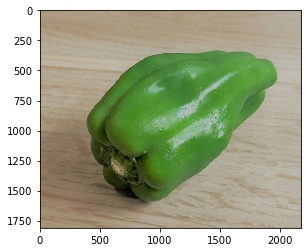

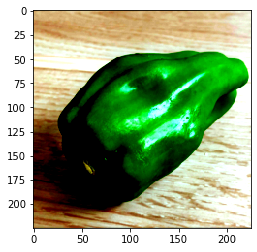

In [4]:
# sample execution (requires torchvision)
import numpy as np
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
%matplotlib inline

input_image = Image.open(image_file)
plt.imshow(input_image)
plt.show()

preprocess = transforms.Compose([
    transforms.Resize(input_size),
    transforms.CenterCrop(input_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
input_tensor = preprocess(input_image)

input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

disp_image = input_tensor.clone()
disp_image = disp_image.numpy().transpose((1, 2, 0))
disp_image = np.float32(disp_image)
disp_image = np.clip(disp_image, 0, 1)
plt.imshow(disp_image)
plt.show()

In [5]:
import numpy as np
import torch

x = np.random.rand(3, input_size, input_size)
x = np.float32(x)
input_tensor = torch.tensor(x)
input_batch2 = input_tensor.unsqueeze(0)

In [6]:
input_batch.shape

torch.Size([1, 3, 225, 225])

In [7]:
input_batch

tensor([[[[0.7248, 0.7248, 0.7077,  ..., 0.8276, 0.8276, 0.8276],
          [0.8104, 0.8104, 0.8104,  ..., 0.9474, 0.9474, 0.9474],
          [0.8276, 0.8276, 0.8276,  ..., 0.9474, 0.9303, 0.9303],
          ...,
          [0.7248, 0.7077, 0.7077,  ..., 0.9817, 0.9474, 0.9474],
          [0.7077, 0.7077, 0.7248,  ..., 1.0159, 1.0159, 1.0159],
          [0.6049, 0.6049, 0.6221,  ..., 0.7591, 0.7591, 0.7762]],

         [[0.5728, 0.5553, 0.5728,  ..., 0.8354, 0.8354, 0.8354],
          [0.6604, 0.6254, 0.6429,  ..., 0.9230, 0.9230, 0.9405],
          [0.6779, 0.6604, 0.6779,  ..., 0.9405, 0.9230, 0.9230],
          ...,
          [0.5728, 0.5728, 0.5728,  ..., 1.0280, 0.9405, 0.8880],
          [0.5203, 0.5378, 0.5203,  ..., 1.0980, 1.0630, 1.0455],
          [0.3978, 0.3978, 0.4153,  ..., 0.6604, 0.6954, 0.7479]],

         [[0.3393, 0.2871, 0.2871,  ..., 0.7576, 0.7576, 0.7402],
          [0.4265, 0.3742, 0.3742,  ..., 0.8622, 0.8622, 0.8448],
          [0.4439, 0.4265, 0.4439,  ..., 0

In [8]:
def define_trt_network(network):
    # Input
    input_tensor = network.add_input(name='input', dtype=trt.float32, shape=(1, 3, input_size, input_size))

    # MaxPool2d
    layer = network.add_pooling_nd( \
        input=input_tensor, type=trt.PoolingType.MAX, window_size=(win_size, win_size))
    layer.stride_nd = (stride, stride)

    # Output
    layer.get_output(0).name = 'output'
    network.mark_output(tensor=layer.get_output(0))

In [9]:
import trt_analyzer
import tensorrt as trt

EXPLICIT_BATCH = 1 << (int)(trt.NetworkDefinitionCreationFlag.EXPLICIT_BATCH)

def build_engine(logger):
    with trt.Builder(logger) as builder, builder.create_network(EXPLICIT_BATCH) as network, builder.create_builder_config() as config, trt.Runtime(TRT_LOGGER) as runtime:
        if hasattr(config, 'set_memory_pool_limit'):
            config.set_memory_pool_limit(trt.MemoryPoolType.WORKSPACE, 1 << 30)
        else:
            config.max_workspace_size = 1 << 30
        # Define the TRT network using weights from the PyTorch model.
        #define_trt_plugin_network(network)
        define_trt_network(network)
        # Get network info
        global net_dict
        net_dict = trt_analyzer.network_dict(network)
        # Build and return an engine.
        plan = builder.build_serialized_network(network, config)
        engine = runtime.deserialize_cuda_engine(plan)
        return engine

In [10]:
import tensorrt as trt
import common

TRT_LOGGER = trt.Logger(trt.Logger.VERBOSE)
net_dict = None
with build_engine(TRT_LOGGER) as engine:
    inputs, outputs, bindings, stream = common.allocate_buffers(engine)
    with engine.create_execution_context() as context:
        inputs[0].host = input_batch.numpy()
        trt_outputs = common.do_inference_v2( \
            context, bindings=bindings, inputs=inputs, outputs=outputs, stream=stream)

[06/27/2022-08:31:28] [TRT] [I] [MemUsageChange] Init CUDA: CPU +201, GPU +0, now: CPU 319, GPU 3674 (MiB)
[06/27/2022-08:31:31] [TRT] [I] [MemUsageChange] Init builder kernel library: CPU +140, GPU +169, now: CPU 479, GPU 3858 (MiB)
[06/27/2022-08:31:31] [TRT] [I] [MemUsageChange] Init CUDA: CPU +0, GPU +0, now: CPU 479, GPU 3858 (MiB)
[06/27/2022-08:31:31] [TRT] [V] Applying generic optimizations to the graph for inference.
[06/27/2022-08:31:31] [TRT] [V] Original: 1 layers
[06/27/2022-08:31:31] [TRT] [V] After dead-layer removal: 1 layers
[06/27/2022-08:31:31] [TRT] [V] After Myelin optimization: 1 layers
[06/27/2022-08:31:31] [TRT] [V] Applying ScaleNodes fusions.
[06/27/2022-08:31:31] [TRT] [V] After scale fusion: 1 layers
[06/27/2022-08:31:31] [TRT] [V] After vertical fusions: 1 layers
[06/27/2022-08:31:31] [TRT] [V] After dupe layer removal: 1 layers
[06/27/2022-08:31:31] [TRT] [V] After final dead-layer removal: 1 layers
[06/27/2022-08:31:31] [TRT] [V] After tensor merging: 1 l

In [11]:
import pandas as pd

pd.DataFrame(net_dict)

,Name,Type,Inputs,Outputs,Type Specific Params
0,(Unnamed Layer* 0) [Pooling],LayerType.POOLING,"(1, 3, 225, 225)","(1, 3, 112, 112)","type=PoolingType.MAX wsize=(3, 3) stride=(2, 2..."


In [12]:
reference = trt_outputs[0].reshape((3, output_size, output_size))
print(reference)

[[[0.82755375 0.878928   0.878928   ... 0.94742703 0.96455175 0.94742703]
  [0.82755375 0.878928   0.878928   ... 0.94742703 0.96455175 0.9816765 ]
  [0.8446785  0.8446785  0.878928   ... 0.94742703 0.96455175 0.9816765 ]
  ...
  [0.673431   0.673431   0.6563062  ... 0.9988013  1.015926   1.0330508 ]
  [0.72480524 0.7590547  0.74193    ... 1.015926   1.015926   0.9816765 ]
  [0.72480524 0.72480524 0.70768046 ... 1.015926   1.015926   1.015926  ]]

 [[0.6778712  0.76540625 0.78291327 ... 0.94047624 0.94047624 0.94047624]
  [0.6778712  0.76540625 0.78291327 ... 0.94047624 0.9754903  0.9754903 ]
  [0.69537824 0.69537824 0.74789923 ... 0.94047624 0.9754903  0.9754903 ]
  ...
  [0.5203082  0.48529422 0.4327732  ... 1.0280112  1.0455183  1.0455183 ]
  [0.5903362  0.62535024 0.5903362  ... 1.0980393  1.0980393  1.0280112 ]
  [0.57282925 0.57282925 0.5903362  ... 1.0980393  1.0980393  1.0980393 ]]

 [[0.44392177 0.51363856 0.5484969  ... 0.8447932  0.8622224  0.8622224 ]
  [0.44392177 0.513638

In [13]:
import sys
import os

cur_path = %pwd
plugin_path = os.path.join(cur_path, 'plugin')
sys.path.append(plugin_path)
from trt_plugin_pb2 import copy_Message
from trt_plugin_pb2 import pooling_Message
import trt_plugin_pb2

In [14]:
import ctypes

lib_file = os.path.join(plugin_path, 'build', 'libPoolingPlugin.so')
lib = ctypes.CDLL(lib_file)

In [15]:
import tensorrt as trt

registry = trt.get_plugin_registry()
print([c.name for c in registry.plugin_creator_list])
print([c.plugin_namespace for c in registry.plugin_creator_list])

['CustomQKVToContextPluginDynamic', 'CustomQKVToContextPluginDynamic', 'CustomQKVToContextPluginDynamic', 'RnRes2Br1Br2c_TRT', 'RnRes2Br1Br2c_TRT', 'RnRes2FullFusion_TRT', 'SmallTileGEMM_TRT', 'RNNTEncoderPlugin', 'DLRM_BOTTOM_MLP_TRT', 'CustomSkipLayerNormPluginDynamic', 'CustomSkipLayerNormPluginDynamic', 'CustomSkipLayerNormPluginDynamic', 'CustomSkipLayerNormPluginDynamic', 'SingleStepLSTMPlugin', 'RnRes2Br2bBr2c_TRT', 'RnRes2Br2bBr2c_TRT', 'CustomGeluPluginDynamic', 'CustomFCPluginDynamic', 'CustomEmbLayerNormPluginDynamic', 'CustomEmbLayerNormPluginDynamic', 'CustomEmbLayerNormPluginDynamic', 'pooling', 'copy']
['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', 'macnica_trt_plugins', 'macnica_trt_plugins']


In [16]:
namespace = 'macnica_trt_plugins'
macnica_creators = [c for c in registry.plugin_creator_list if c.plugin_namespace == namespace]
for c in macnica_creators:
    registry.register_creator(c, namespace)

In [17]:
def define_trt_plugin_network(network):
    # Input
    input_tensor = network.add_input(name='input', dtype=trt.float32, shape=(1, 3, input_size, input_size))
    
    ### Custom Pooling Layer with CUDA or cuDNN ###
    creator = registry.get_plugin_creator( \
        type='pooling', version='1', plugin_namespace='macnica_trt_plugins')
    sz = input_tensor.shape
    message = pooling_Message( \
        dims=sz, mode=trt_plugin_pb2.Maximum, window=[win_size, win_size], \
        stride=[stride, stride], impl=trt_plugin_pb2.CUDA)
    plg = creator.deserialize_plugin('pooling', message.SerializeToString())
    layer = network.add_plugin_v2(inputs=[input_tensor], plugin=plg)

    # Output
    layer.get_output(0).name = 'output'
    network.mark_output(tensor=layer.get_output(0))

In [18]:
import trt_analyzer
import tensorrt as trt

EXPLICIT_BATCH = 1 << (int)(trt.NetworkDefinitionCreationFlag.EXPLICIT_BATCH)

def build_engine2(logger):
    with trt.Builder(logger) as builder, builder.create_network(EXPLICIT_BATCH) as network, builder.create_builder_config() as config, trt.Runtime(TRT_LOGGER) as runtime:
        if hasattr(config, 'set_memory_pool_limit'):
            config.set_memory_pool_limit(trt.MemoryPoolType.WORKSPACE, 1 << 30)
        else:
            config.max_workspace_size = 1 << 30
        # Define the TRT network using weights from the PyTorch model.
        define_trt_plugin_network(network)
        #define_trt_network(network)
        # Get network info
        global net_dict
        net_dict = trt_analyzer.network_dict(network)
        # Build and return an engine.
        plan = builder.build_serialized_network(network, config)
        engine = runtime.deserialize_cuda_engine(plan)
        return engine

In [19]:
net_dict = None
with build_engine2(TRT_LOGGER) as engine:
    inputs, outputs, bindings, stream = common.allocate_buffers(engine)
    with engine.create_execution_context() as context:
        inputs[0].host = input_batch.numpy()
        trt_outputs = common.do_inference_v2( \
            context, bindings=bindings, inputs=inputs, outputs=outputs, stream=stream)

[06/27/2022-08:31:35] [TRT] [I] [MemUsageChange] Init CUDA: CPU +0, GPU +0, now: CPU 815, GPU 4394 (MiB)
[06/27/2022-08:31:35] [TRT] [I] [MemUsageChange] Init CUDA: CPU +0, GPU +0, now: CPU 815, GPU 4394 (MiB)
[06/27/2022-08:31:35] [TRT] [V] Applying generic optimizations to the graph for inference.
[06/27/2022-08:31:35] [TRT] [V] Original: 1 layers
[06/27/2022-08:31:35] [TRT] [V] After dead-layer removal: 1 layers
[06/27/2022-08:31:35] [TRT] [V] After Myelin optimization: 1 layers
[06/27/2022-08:31:35] [TRT] [V] Applying ScaleNodes fusions.
[06/27/2022-08:31:35] [TRT] [V] After scale fusion: 1 layers
[06/27/2022-08:31:35] [TRT] [V] After vertical fusions: 1 layers
[06/27/2022-08:31:35] [TRT] [V] After dupe layer removal: 1 layers
[06/27/2022-08:31:35] [TRT] [V] After final dead-layer removal: 1 layers
[06/27/2022-08:31:35] [TRT] [V] After tensor merging: 1 layers
[06/27/2022-08:31:35] [TRT] [V] After slice removal: 1 layers
[06/27/2022-08:31:35] [TRT] [V] After concat removal: 1 layer

In [20]:
pd.DataFrame(net_dict)

,Name,Type,Inputs,Outputs,Type Specific Params
0,(Unnamed Layer* 0) [PluginV2Ext],LayerType.PLUGIN_V2,"(1, 3, 225, 225)","(1, 3, 112, 112)",


In [21]:
result = trt_outputs[0].reshape((3, output_size, output_size))
print(type(result[0][0][0]))
print(result)

<class 'numpy.float32'>
[[[0.82755375 0.878928   0.878928   ... 0.94742703 0.96455175 0.94742703]
  [0.82755375 0.878928   0.878928   ... 0.94742703 0.96455175 0.9816765 ]
  [0.8446785  0.8446785  0.878928   ... 0.94742703 0.96455175 0.9816765 ]
  ...
  [0.673431   0.673431   0.6563062  ... 0.9988013  1.015926   1.0330508 ]
  [0.72480524 0.7590547  0.74193    ... 1.015926   1.015926   0.9816765 ]
  [0.72480524 0.72480524 0.70768046 ... 1.015926   1.015926   1.015926  ]]

 [[0.6778712  0.76540625 0.78291327 ... 0.94047624 0.94047624 0.94047624]
  [0.6778712  0.76540625 0.78291327 ... 0.94047624 0.9754903  0.9754903 ]
  [0.69537824 0.69537824 0.74789923 ... 0.94047624 0.9754903  0.9754903 ]
  ...
  [0.5203082  0.48529422 0.4327732  ... 1.0280112  1.0455183  1.0455183 ]
  [0.5903362  0.62535024 0.5903362  ... 1.0980393  1.0980393  1.0280112 ]
  [0.57282925 0.57282925 0.5903362  ... 1.0980393  1.0980393  1.0980393 ]]

 [[0.44392177 0.51363856 0.5484969  ... 0.8447932  0.8622224  0.8622224 

In [22]:
print(sum(abs(result.flatten() - reference.flatten())) / len(result.flatten()))

0.0


(3, 112, 112)


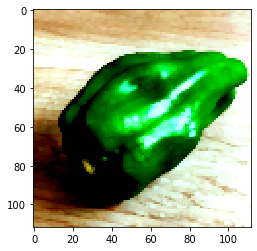

In [23]:
disp_image = result.reshape(3, output_size, output_size)
print(disp_image.shape)
disp_image = disp_image.transpose((1, 2, 0))
disp_image = np.clip(disp_image, 0, 1)
plt.imshow(disp_image)
plt.show()